<h1><center>DALLAS CRIME DATA</center></h1>
<h2><center>MSDS 7331 Mini Project</center></h2>
<h2><center>SVM and Logistic Regression Modeling</center></h2>

<h4><center>Team Members</center></h4>

           Yejur Singh Kunwar           Bin Yu               Vivek Viswanathan          Kevin Mendonsa
              Dallas, TX               Dallas, TX               Dallas, TX                Irvine, CA

# Introduction

We will be using Dallas crime datset where police incidents were recorded. For this miniproject, main dataframe that we will be utilizing is the saved dataframe from LAB 1, details for this dataset can be found in LAB 1.  

The data shape was 255154 observations with 44 attributes.

- Logistic Regression
- SVM

# Assessing Logistic Regression Model vs. Support Vector Model

### To be deleted

[50 points] Create a logistic regression model and a support vector machine model for the classification task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). Adjust parameters of the models to make them more accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use. That is, the SGDClassifier is fine to use for optimizing logistic regression and linear support vector machines. For many problems, SGD will be required in order to train the SVM model in a reasonable timeframe.

##### Importing necessary packages for python

In [154]:
# Importing necessary packages for python
import pandas as pd
import numpy as np
import datetime
import time
import string
from dateutil.relativedelta import relativedelta
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
pd.set_option('mode.chained_assignment', None)
# plt.style.use('ggplot')
import seaborn as sns
from itertools import cycle, islice
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import StratifiedKFold
from sklearn import metrics as mt
from __future__ import print_function, division
from patsy import dmatrices, dmatrix
from sklearn.calibration import CalibratedClassifierCV
from sklearn.decomposition import IncrementalPCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

##### Importing files 

In [265]:
path = "../Data/" # Generic path
incident = pd.read_csv(path + 'LAB1_completed_Dataset_clean.csv', low_memory= False)
#-------------------------------
# LOADING SUPPORTING DATA SETS
#-------------------------------
# Dallas area population dataset
#-------------------------------
population = pd.read_csv(path + 'Population.csv', low_memory=False)
#--------------------------------------------


### Response Variable Analysis

In [266]:
# 30288 rows has 0 respone time which is incident is cancealled or didn't dispatch
incident[incident['Response_time']==0]['Response_time'].value_counts()

0.0    30288
Name: Response_time, dtype: int64

In [267]:
# remove the 0 response time records from the data set.
incident = incident[incident['Response_time']!=0]

In [268]:
#incident.describe()

D:\Anaconda3\envs\BINENV\lib\site-packages\numpy\lib\histograms.py:746: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
D:\Anaconda3\envs\BINENV\lib\site-packages\numpy\lib\histograms.py:747: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([101980.,  38130.,  22772.,  14385.,  12274.,   9720.,   7214.,
          6939.,   5653.,   4715.]),
 array([ 0. ,  9.7, 19.4, 29.1, 38.8, 48.5, 58.2, 67.9, 77.6, 87.3, 97. ]),
 <a list of 10 Patch objects>)

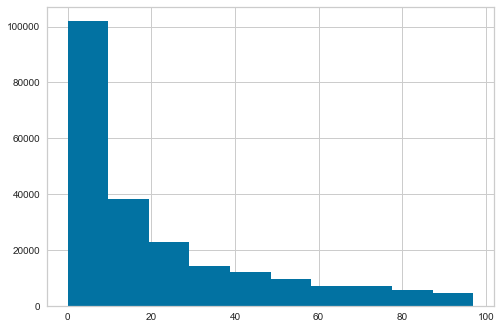

In [269]:
# draw histogram for response time attibute
plt.hist(incident['Response_time'],range=[0,97])

In [270]:
# get the median of the response time 
from numpy import median
median(incident['Response_time'].dropna())

11.0

In [271]:
incident['Response_time'].describe()

count    223782.000000
mean         21.871299
std          23.859860
min           1.000000
25%           4.000000
50%          11.000000
75%          32.000000
max          97.000000
Name: Response_time, dtype: float64

In [272]:
incident.loc[incident['Weapon_Used'] == 'None', 'Weapon_Used_Fact'] = 0
incident.loc[incident['Weapon_Used'] != 'None', 'Weapon_Used_Fact'] = 1
if 'Weapon_Used' in incident:
    del incident['Weapon_Used'] # get rid of the class label

In [273]:
# UCR_Offense_Name change this

incident.loc[:,'UCR_Offense_Name'] = incident['UCR_Offense_Name'].fillna("MISSING")

THEFT_FRAUD     = dict.fromkeys(['THEFT/BMV', 'THEFT ORG RETAIL', 'BURGLARY-RESIDENCE', 'OTHER THEFTS',
                                 'ROBBERY-INDIVIDUAL','THEFT/SHOPLIFT', 'BURGLARY-BUSINESS', 'FORGE & COUNTERFEIT', 
                                 'FRAUD', 'EMBEZZLEMENT','ROBBERY-BUSINESS','THEFT ORG RETAIL'],"THEFT_FRAUD" ) 
MVA_TRAFFIC      =dict.fromkeys(['ACCIDENT MV', 'MOTOR VEHICLE ACCIDENT', 'UUMV', 'TRAFFIC VIOLATION',
                                 'TRAFFIC FATALITY'],"MVA_TRAFFIC" )        
WEAPONS_FIREARMS =dict.fromkeys(['WEAPONS', 'ARSON', 'INJURED FIREARM'], "WEAPONS_FIREARMS")         
ASSUALT          = dict.fromkeys(['ASSAULT','VANDALISM & CRIM MISCHIEF', 'AGG ASSAULT - NFV', 'OFFENSE AGAINST CHILD',
                                  'AGG ASSAULT - FV'], "ASSUALT")
OTHERS_THREATS   = dict.fromkeys(['FOUND', 'OTHERS', 'LOST', 'CRIMINAL TRESPASS', 'DISORDERLY CONDUCT', 
                                  'ANIMAL BITE','INJURED HOME','INJURED PUBLIC', 'TERRORISTIC THREAT', 
                                  'EVADING', 'INJURED OCCUPA', 'ORANIZED CRIME', 'KIDNAPPING', 
                                  'RESIST ARREST','FAIL TO ID', 'HUMAN TRAFFICKING', 'MISSING'], "OTHERS_THREATS")
INTOXICATION     = dict.fromkeys(['DRUNK & DISORDERLY', 'DWI', 'NARCOTICS & DRUGS', 'LIQUOR OFFENSE', 
                                  'INTOXICATION MANSLAUGHTER'],"INTOXICATION")
MURDER_DEATH     = dict.fromkeys(['SUDDEN DEATH&FOUND BODIES','MURDER'], "MURDER_DEATH")
                    

incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(THEFT_FRAUD)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(MVA_TRAFFIC)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(WEAPONS_FIREARMS)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(ASSUALT)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(OTHERS_THREATS)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(INTOXICATION)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(MURDER_DEATH)

In [274]:
# # FILTERING OUT UNNECESSARY NULL DATA
incident = incident[incident['Watch']!=0]
incident = incident[(incident['Victim_Age']>=0) & (incident['Victim_Age']<=90)]
incident = incident[incident['Victim_Race']!="Unknown"]
incident = incident[incident['Victim_Type']!="Unknown"]
incident= incident[incident.Number_of_offense != "RP"]
incident.loc[:,'Social_crime_score'] = incident['Hate_Crime']+incident['Gang_Related_Offense']+incident['Drug_Related']+incident['Weapon_Used_Fact']
incident = incident[incident['Victim_Gender']!="U"]
incident.loc[:,'IsMale'] = incident.Victim_Gender=='M' 
incident.IsMale = incident.IsMale.astype(np.int)
incident.loc[:,'Number_of_offense']= incident.Number_of_offense.astype(np.int)

incident.loc[:,'Victim_Age'] = incident['Victim_Age'].astype(np.int)

incident.loc[:,'Response_time'] = incident['Response_time'].fillna(incident['Response_time'].mean()).astype(np.int)
# 0 - fast, 1 - middium, 2 - low
incident.loc[:,'Responsetime_cat'] = pd.cut(incident.Response_time,[0,11,25,999],3,labels=[0,1,2])

# incident= incident[incident['Responsetime_cat']!=np.nan]

incident['UCR_Offense_Name'] = pd.Categorical(incident['UCR_Offense_Name']).codes
incident['Day1_of_the_Week'] = pd.Categorical(incident['Day1_of_the_Week']).codes
incident['Division'] = pd.Categorical(incident['Division']).codes


In [275]:
incident['Degree']=incident['RMS_Code'].astype(str).str[:2]
incident['Degree_Fact'] = pd.Categorical(incident['Degree']).codes



In [276]:
incident.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201689 entries, 0 to 255153
Data columns (total 44 columns):
Year_of_Incident           201689 non-null int64
Watch                      201689 non-null int64
Type_of_Incident           201689 non-null object
Type_Location              198121 non-null object
Reporting_Area             201566 non-null float64
Beat                       201637 non-null float64
Division                   201689 non-null int8
Sector                     201637 non-null float64
Council_District           201689 non-null object
Day1_of_the_Week           201689 non-null int8
Person_Involvement_Type    201689 non-null object
Victim_Type                201689 non-null object
Victim_Race                201689 non-null object
Victim_Gender              201689 non-null object
Victim_Age                 201689 non-null int32
Offense_Status             201324 non-null object
Victim_Condition           17122 non-null object
Hate_Crime                 201689 non-null i

In [277]:
#Create correlation matrix
CorrMatrix = incident.corr()

# Highest Correlation Pairs
corrPairs = CorrMatrix.unstack().sort_values(kind="quicksort")
#- REMOVE DUPLICATES
corrPairs = corrPairs[::2]
corrPairs = corrPairs[corrPairs.index.get_level_values(0) != corrPairs.index.get_level_values(1)]
with pd.option_context('display.max_rows',20):
    print(corrPairs)

Division            Y_Coordinate         -0.643603
Sector              X_Coordinate         -0.431452
Beat                X_Coordinate         -0.429325
Reporting_Area      X_Coordinate         -0.352009
UCR_Offense_Name    Degree_Fact          -0.278610
Year_of_Incident    Longitude            -0.212045
                    Latitude             -0.212019
Arrest_status       UCR_Offense_Name     -0.198657
Y_Coordinate        Reporting_Area       -0.141704
Division            X_Coordinate         -0.133813
                                            ...   
                    Beat                  0.296908
Beat                Reporting_Area        0.332316
Sector              Reporting_Area        0.332536
Year_of_Incident    Social_crime_score    0.503496
UCR_Code            Degree_Fact           0.507150
Weapon_Used_Fact    Year_of_Incident      0.540173
Call_Received_Hour  Watch                 0.679547
Weapon_Used_Fact    Social_crime_score    0.940273
Longitude           Latitude   

# MODELS

#### Preparation of Data

The incident dataset is further cleaned and and prepared in right format to feed into model algorithm. 

The attributes where null or empty values were replaced with Unknows or other category is removed in order to reduce data ambuigity in the model for selected attributes. 

The data is splitted to response variable (response_category_classification) which will be called "Y" and explanatory variables or attributes "X" for placing it into the algoirith model. 

The main dataset is splitted into training and test dataset by 80/20 split method.



In [278]:
inci_imp = incident[['Day1_of_the_Week',  'Division',
#                      'Response_time',
                     'Responsetime_cat','Arrest_status','Social_crime_score', 'IsMale','Call_Received_Hour',
                    'UCR_Offense_Name',
                    ]].dropna()

In [279]:
inci_imp.isnull().sum()

Day1_of_the_Week      0
Division              0
Responsetime_cat      0
Arrest_status         0
Social_crime_score    0
IsMale                0
Call_Received_Hour    0
UCR_Offense_Name      0
dtype: int64

## TRAINING AND TEST SPLIT

In [280]:
inci_imp.columns

Index(['Day1_of_the_Week', 'Division', 'Responsetime_cat', 'Arrest_status',
       'Social_crime_score', 'IsMale', 'Call_Received_Hour',
       'UCR_Offense_Name'],
      dtype='object')

In [281]:
from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
#if 'UCR_Offense_Name' in inci_imp:
y = inci_imp['Responsetime_cat'].values # get the labels we want
del inci_imp['Responsetime_cat'] # get rid of the class label
X = inci_imp.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


In [282]:
# import matplotlib.pyplot as plt

# from sklearn.ensemble import GradientBoostingClassifier

# from yellowbrick.features.importances import FeatureImportances

# features = ['Day1_of_the_Week',  'Division',
# #                      'Response_time',
#                      'Responsetime_cat','Arrest_status','Social_crime_score', 'IsMale','Call_Received_Hour',
#                      'UCR_Offense_Name'
#                     ]
# # Create a new matplotlib figure
# fig = plt.figure()
# ax = fig.add_subplot()
# labels = list(map(lambda s: s.title(), features))
# viz = FeatureImportances(GradientBoostingClassifier(),labels=labels, ax=ax)
# viz.fit(X, y)
# viz.poof()

___
# Logistic Regression
Now let's use Logistic Regression from `scikit-learn`. The documentation can be found here:

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [283]:
# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None) # get object

# now we can use the cv_object that we setup before to iterate through the 
#    different training and testing sets. Each time we will reuse the logisitic regression 
#    object, but it gets trained on different data each time we use it.

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test) # get test set precitions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    iter_num+=1
    
# Also note that every time you run the above code
#   it randomly creates a new training and testing set, 
#   so accuracy will be different each time

D:\Anaconda3\envs\BINENV\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda3\envs\BINENV\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


====Iteration 0  ====
accuracy 0.5098615399940233
confusion matrix
 [[19949     0   592]
 [ 7435     0   260]
 [11395     0   525]]


D:\Anaconda3\envs\BINENV\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda3\envs\BINENV\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


====Iteration 1  ====
accuracy 0.508740910449248
confusion matrix
 [[19944     0   547]
 [ 7438     0   273]
 [11469     0   485]]


D:\Anaconda3\envs\BINENV\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda3\envs\BINENV\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


====Iteration 2  ====
accuracy 0.5082926586313378
confusion matrix
 [[19889     0   567]
 [ 7435     0   313]
 [11430     0   522]]


### Class Balances

D:\Anaconda3\envs\BINENV\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


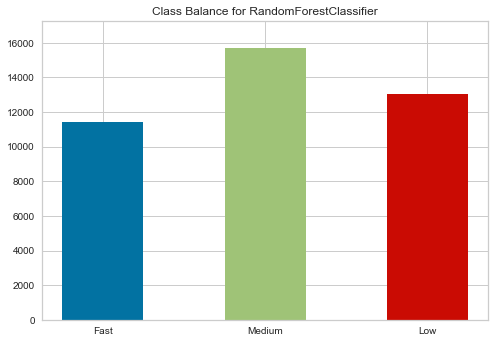

In [263]:
from sklearn.ensemble import RandomForestClassifier

from yellowbrick.classifier import ClassBalance


# Specify the features of interest and the classes of the target
features = ['Day1_of_the_Week',  'Division',
#                      'Response_time',
                     'Arrest_status','Social_crime_score', 'IsMale','Call_Received_Hour',
                    'UCR_Offense_Name',
                    ]
classes = ["Fast", "Medium","Low"]


# Instantiate the classification model and visualizer
forest = RandomForestClassifier()
visualizer = ClassBalance(forest, classes=classes)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

In [18]:
# this does the exact same thing as the above block of code, but with shorter syntax

for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    lr_clf.fit(X[train_indices],y[train_indices])  # train object
    y_hat = lr_clf.predict(X[test_indices]) # get test set precitions

    # print the accuracy and confusion matrix 
    print("====Iteration",iter_num," ====")
    print("accuracy", mt.accuracy_score(y[test_indices],y_hat)) 
    print("confusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat))

D:\Anaconda3\envs\BINENV\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


====Iteration 0  ====
accuracy 0.744645881063851
confusion matrix
 [[29902     0]
 [10254     0]]


D:\Anaconda3\envs\BINENV\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


====Iteration 1  ====
accuracy 0.7439236975794402
confusion matrix
 [[29873     0]
 [10283     0]]


D:\Anaconda3\envs\BINENV\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


====Iteration 2  ====
accuracy 0.7429524853073015
confusion matrix
 [[29834     0]
 [10322     0]]


In [19]:
# and here is an even shorter way of getting the accuracies for each training and test set
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object) # this also can help with parallelism
print(accuracies)

TypeError: take_nd() got an unexpected keyword argument 'axis'

In [ ]:
import sklearn
print(sklearn.__version__)

In [ ]:
# here we can change some of the parameters interactively
from ipywidgets import widgets as wd

def lr_explor(cost):
    lr_clf = LogisticRegression(penalty='l2', C=cost, class_weight=None) # get object
    accuracies = cross_val_score(lr_clf,X,y=y,cv=cv_object) # this also can help with parallelism
    print(accuracies)

wd.interact(lr_explor,cost=(0.001,5.0,0.05),__manual=True)

#### WEIGHTS

In [ ]:
# interpret the weights

# iterate over the coefficients
weights = lr_clf.coef_.T # take transpose to make a column vector
variable_names = inci_imp.columns
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])
    

In [ ]:
from sklearn.preprocessing import StandardScaler

# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

# train the model just as before
lr_clf = LogisticRegression(penalty='l2', C=0.05) # get object, the 'C' value is less (can you guess why??)
lr_clf.fit(X_train_scaled,y_train)  # train object

y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf )

# sort these attributes and spit them out
zip_vars = zip(lr_clf.coef_.T,inci_imp.columns) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

In [ ]:
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


weights = pd.Series(lr_clf.coef_[0],index=inci_imp.columns)
weights.plot(kind='bar')
plt.show()

For more improvement and guarding against overfitting: At this point it would make sense to remove variables that are highly related to one another or ones that are irrelevant and keep going with the weights analysis. What variables would you remove?

In [ ]:
from sklearn.preprocessing import StandardScaler
# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)

from sklearn.pipeline import Pipeline
# you can apply the StandardScaler function inside of the cross-validation loop 
#  but this requires the use of PipeLines in scikit. 
#  A pipeline can apply feature pre-processing and data fitting in one compact notation
#  Here is an example!

std_scl = StandardScaler()
lr_clf = LogisticRegression(penalty='l2', C=0.05) 

# create the pipline
piped_object = Pipeline([('scale', std_scl),  # do this
                         ('logit_model', lr_clf)]) # and then do this

weights = []
# run the pipline cross validated
for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    piped_object.fit(X[train_indices],y[train_indices])  # train object
    # it is a little odd getting trained objects from a  pipeline:
    weights.append(piped_object.named_steps['logit_model'].coef_[0])
    

weights = np.array(weights)

In [ ]:
import plotly
plotly.offline.init_notebook_mode() # run at the start of every notebook

error_y=dict(
            type='data',
            array=np.std(weights,axis=0),
            visible=True
        )

graph1 = {'x': inci_imp.columns,
          'y': np.mean(weights,axis=0),
    'error_y':error_y,
       'type': 'bar'}

fig = dict()
fig['data'] = [graph1]
fig['layout'] = {'title': 'Logistic Regression Weights, with error bars'}

plotly.offline.iplot(fig)

In [ ]:
from sklearn.model_selection import train_test_split

# # Load the data
# df = load_data('concrete')
# feature_names = ['cement', 'slag', 'ash', 'water', 'splast', 'coarse', 'fine', 'age']
# target_name = 'strength'

# Get the X and y data from the DataFrame

if 'Responsetime_cat' in inci_imp:
    y = inci_imp['Responsetime_cat'].as_matrix() # get the labels we want
    del inci_imp['Responsetime_cat'] # get rid of the class label
    X = inci_imp.as_matrix() # use everything else to predict
# X = df[feature_names].as_matrix()
# y = df[target_name].as_matrix()

# Create the train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
from sklearn.linear_model import Lasso

from yellowbrick.regressor import PredictionError

# Instantiate the linear model and visualizer
lasso = Lasso()
visualizer = PredictionError(lasso)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()

In [ ]:
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingClassifier

from yellowbrick.features.importances import FeatureImportances

# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

viz = FeatureImportances(GradientBoostingClassifier(), ax=ax)
viz.fit(X, y)
viz.poof()

In [ ]:
#CREDIT TO : http://www.scikit-yb.org/en/latest/api/classifier/classification_report.html


from sklearn.model_selection import train_test_split

# Load the classification data set
# data = load_data("occupancy")

# Specify the features of interest and the classes of the target
# features = [
#     "temperature", "relative humidity", "light", "C02", "humidity"
# ]
classes = ["FAST","MEDIUM","NON_URGENT","LESS_URGENT"]

# # Extract the numpy arrays from the data frame
# X = data[features].as_matrix()
# y = data.occupancy.as_matrix()

# Create the train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


from sklearn.naive_bayes import GaussianNB
from yellowbrick.classifier import ClassificationReport

# Instantiate the classification model and visualizer
bayes = GaussianNB()
visualizer = ClassificationReport(bayes, classes=classes, support=True)

visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

In [ ]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from yellowbrick.classifier import ConfusionMatrix

model = LogisticRegression()

# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(model, classes=[0,1,2,3])

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

# How did we do?
cm.poof()

## SVM

In [ ]:
X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) 

In [ ]:
# lets investigate SVMs on the data and play with the parameters and kernels
from sklearn.svm import SVC

# train the model just as before
svm_clf = SVC(C=1.0, kernel='linear', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)

In [ ]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from yellowbrick.classifier import ConfusionMatrix

model = SVC()

# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(model, classes=[0,1,2,3])

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

# How did we do?
cm.poof()

In [ ]:
# look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

In [ ]:
# if using linear kernel, these make sense to look at (not otherwise, why?)
print(svm_clf.coef_)
weights = pd.Series(svm_clf.coef_[0],index=inci_imp.columns)
weights.plot(kind='bar')

In [ ]:
# Now let's do some different analysis with the SVM and look at the instances that were chosen as support vectors

# now lets look at the support for the vectors and see if we they are indicative of anything
# grabe the rows that were selected as support vectors (these are usually instances that are hard to classify)

# make a dataframe of the training data
df_tested_on = inci_imp.iloc[train_indices] # saved from above, the indices chosen for training
# now get the support vectors from the trained model
df_support = df_tested_on.iloc[svm_clf.support_,:]

df_support['Responsetime_cat'] = y[svm_clf.support_] # add back in the 'Survived' Column to the pandas dataframe
inci_imp['Responsetime_cat'] = y # also add it back in for the original data
df_support.info()

In [ ]:
# now lets see the statistics of these attributes
from pandas.tools.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['Responsetime_cat'])
df_grouped = inci_imp.groupby(['Responsetime_cat'])

# plot KDE of Different variables
vars_to_plot = ['Victim_Age','Arrest_status','IsMale','Social_crime_score']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['Fast','Medium','Slow', 'Other'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['Fast','Medium','Slow', 'Other'])
    plt.title(v+' (Original)')



# Logistic Regression vs. Support Vector Machine Models - Comparison

##### Vivek to work on this section

###### To be deleted 

###### [10 points] Discuss the advantages of each model for each classification task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail.

## Logistic Regression 
Logistic Regresssion is used in many fields of application in which the response variable is binary. Regression models for binary responses, therefore are used to describe probabilities as functions of explanatory variables. It explain a function (logarithm of odds) of mean or probability rather than the mean itself. The interpretations of logistic regression coefficients are made in terms of statemens about odds and odds ratios.
## Support Vector Machine
This technique has its roots in statistical learning theory and has shown promision empirical results in many practical applications like text categorization. It works well with high dimensional data and avoids the curse of dimenstionality problem. Another unique aspect of this approach is that it represents the decision boundary using a subset of the training examples known as the **Support Vectors**. 
### Hyperplane
In a p-dimensional space, a hyperplane is a flat affine subspace of dimension p−1. For instance, in two dimensions, a hyperplane is a line. In three dimensions, a hyperplane is a flat two-dimensional subspace—that is, a plane. In p > 3 dimensions, it can be hard to visualize a hyperplane, but the notion of a (p − 1)-dimensional flat subspace still applies.

## Superior Prediction Accuracy
While Logistic Regression fits a model as well as possible using a Training data set, and therefore leading to a substantial number of misclassified patients when applied prospectively on a Test data set. Logistic regression cannot identify possible non-linear structures in the test data set. 

SVM tries to generalize well when building a model using the given Training data set. In SVM, the generalization performance is optimized by minimizing the classification error on the training set together with minimizing the complexity of the model. This trade-off is called the regularization parameter. SVM can handled more complex decision boundaries (read non-linear). Most importantly, the SVM hs means to prevent the model from being sensitive to outliers in the data, resulting in a model that is capable of making good predictions for prospective analysis.

## Superior Efficiency


##### Source: 
* Introduction to Data Mining - Tan, Steinbach and Kumar - Chapter 5
* ISLR Sixth Print Edition - Casella, Fienberg, Olkin - Chapter 9
* MSDS-6372 Class Slides 
* The Statistical Sleuth, 3rd Edition - Ramsey, Schafer - Chapter 20

# Logistic Regression
## Interpreting feature importance using weights

## To be worked on as a team after model is finalized

[30 points] Use the weights from logistic regression to interpret the importance of different features for the classification task. Explain your interpretation in detail. Why do you think some variables are more important?

# SVM - Data Insights

## To be worked on as a team after model is finalized

[10 points] Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain. If you used stochastic gradient descent (and therefore did not explicitly solve for support vectors), try subsampling your data to train the SVC model— then analyze the support vectors from the subsampled dataset.

# DR. DREW'S EXAMPLES

Dr. Jake Drew's Notebook

@misc{BelkNCEARepo,
     author = {Drew, J.},
     title = {The Belk Endowment Educational Attainment Data Repository for North Carolina Public Schools},
     year = {2018},
     publisher = {GitHub},
     journal = {GitHub repository},
     howpublished = {\url{https://github.com/jakemdrew/EducationDataNC}}
}

https://github.com/jakemdrew/EducationDataNC/blob/master/Other%20Projects/iPython%20Notebooks/Machine%20Learning/Graduation%20Rates%20February%202018%20-%204%20Years%20Expanded.ipynb

In [ ]:
# create x explanatory and y response variables for regression
Y = inci_imp['Responsetime_cat']
X = inci_imp.drop(['Responsetime_cat'], axis=1)


#inspect data 
X.info()

## Cross Validation
Cross validation is performed using repeated holdout using ShuffleSplit()

- Ten folds are used
- The split is: 90% training data and 10% test data
- A random seed is set so the same random test and training splits are used each time cross validation is performed.

In [ ]:
#Divide data into test and training splits
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.10, random_state=0)

Custom Scorers for Evaluating Regression Models
All regression models created in this notebook are validated using the following metrics:

Mean Absolute Error (MAE)
Root Mean Squared Error (RMSE) - https://stackoverflow.com/questions/17197492/root-mean-square-error-in-python
Mean Absolute Percentage Error (MAPE) - https://stackoverflow.com/questions/42250958/how-to-optimize-mape-code-in-python
For details on making scorers to return multiple mean error scores see:

http://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html
https://github.com/scikit-learn/scikit-learn/pull/7388
https://github.com/drorata/multiscorer

In [ ]:
#Use mean absolute error (MAE) to score the regression models created 
#(the scale of MAE is identical to the response variable)
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error

#Function for Root mean squared error
#https://stackoverflow.com/questions/17197492/root-mean-square-error-in-python
def rmse(y_actual, y_predicted):
    return np.sqrt(mean_squared_error(y_actual, y_predicted))

#Function for Mean Absolute Percentage Error (MAPE) - Untested
#Adapted from - https://stackoverflow.com/questions/42250958/how-to-optimize-mape-code-in-python
def mape(y_actual, y_predicted): 
    mask = y_actual != 0
    return (np.fabs(y_actual - y_predicted)/y_actual)[mask].mean() * 100

#Create scorers for rmse and mape functions
mae_scorer = make_scorer(score_func=mean_absolute_error, greater_is_better=False)
rmse_scorer = make_scorer(score_func=rmse, greater_is_better=False)
mape_scorer = make_scorer(score_func=mape, greater_is_better=False)

#Make scorer array to pass into cross_validate() function for producing mutiple scores for each cv fold.
errorScoring = {'MAE':  mae_scorer, 
                'RMSE': rmse_scorer,
                'MAPE': mape_scorer
               }


Regression Model Evaluation
All regression models are evaluated using the regression model evaluation function below:

The following regression evaluation function uses the cross validation object and the custom scorers in the two cells above in combination with sklearn.model_selection's cross_validate function to perform cross validation for regression estimators.
The cross validation object above uses a random seed to ensure that all regression estimators are tested on the same randomly selected records for each cross validation fold.
Custom scorers are created using the three chosen mean error scores and passed into cross_validate(), so all three scores are calcualted using a single call to cross_validate().
All of this functionality is wrapped within the custom EvaluateRegressionEstimator() function below so multiple regression models may be tested using the same test / train cv data and evaluation scores producing a consistent output for each model without the need to re-write the same code over and over.

In [ ]:
from sklearn.model_selection import cross_validate

def EvaluateRegressionEstimator(regEstimator, X, y, cv):
    
    scores = cross_validate(regEstimator, X, y, scoring=errorScoring, cv=cv, return_train_score=True)

    #cross val score sign-flips the outputs of MAE
    # https://github.com/scikit-learn/scikit-learn/issues/2439
    scores['test_MAE'] = scores['test_MAE'] * -1
    scores['test_MAPE'] = scores['test_MAPE'] * -1
    scores['test_RMSE'] = scores['test_RMSE'] * -1

    #print mean MAE for all folds 
    maeAvg = scores['test_MAE'].mean()
    print_str = "The average MAE for all cv folds is: \t\t\t {maeAvg:.5}"
    print(print_str.format(maeAvg=maeAvg))

    #print mean test_MAPE for all folds
    scores['test_MAPE'] = scores['test_MAPE']
    mape_avg = scores['test_MAPE'].mean()
    print_str = "The average MAE percentage (MAPE) for all cv folds is: \t {mape_avg:.5}"
    print(print_str.format(mape_avg=mape_avg))

    #print mean MAE for all folds 
    RMSEavg = scores['test_RMSE'].mean()
    print_str = "The average RMSE for all cv folds is: \t\t\t {RMSEavg:.5}"
    print(print_str.format(RMSEavg=RMSEavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['MAE'] = scores['test_MAE']
    scoresResults['MAPE'] = scores['test_MAPE']
    scoresResults['RMSE'] = scores['test_RMSE']
    return scoresResults

# SVM

This model uses Support Vector Machines for regression of continuous variables (SVR). Please see documentation here:"

http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html
http://scikit-learn.org/stable/modules/svm.html

In [ ]:
#Create a Linear regression object and perform a grid search to find the best parameters
from sklearn.svm import SVR
reg = SVR()

#Set up SVR parameters to test (WARNING: Creates 320 models!!!) 
costs = [0.001, 0.1, 1, 10]
defGamma = 1 / X.shape[1]  #This is the default value for the gamma parameter
gammas = [defGamma, 0.1, 1, 10]
kernels = ['rbf','linear']
parameters = {'C': costs, 'gamma' : gammas, 'kernel': kernels}

#Create a grid search object using the parameters above
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=reg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X, Y)

In [ ]:
#Display the best estimator parameters
regGridSearch.best_estimator_

In [ ]:
from sklearn.svm import SVR

#Create a regression estimator with best parameters for cross validation
regEstimator = SVR(C=0.001, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
                   kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
EvaluateRegressionEstimator(regEstimator, X, Y, cv)

In [ ]:
#Do we predict graduation rates greater than 100%?
regEstimator = SVR(C=0.001, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
                   kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

regEstimator.fit(X, Y)
yhat = regEstimator.predict(X)
print("Yhat Max: ", yhat.max())

# LOGIT

This model uses a custom Logit model based on transformations of the Linear Regression object. Please see documentation here:"

https://stackoverflow.com/questions/33845539/modelling-probabilities-in-a-regularized-logistic-regression-model-in-python
https://stackoverflow.com/questions/44234682/how-to-use-sklearn-when-target-variable-is-a-proportion

In [ ]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression

class LogitRegression(LinearRegression):

    def fit(self, x, p):
        p[p==0] = 0.009    #0.1111111111111111 
        p[p==1] = 0.991    #0.9999999999999999  big precision seems to kill MAE scores here?
        #e = 0.0000000000000001
        #p = p * e + 0.5 * e                    This technique was really bad too. 
        p = np.asarray(p)
        y = np.log(p / (1 - p))
        return super(LogitRegression, self).fit(x, y)

    def predict(self, x):
        y = super(LogitRegression, self).predict(x)
        yhat = 1 / (np.exp(-y) + 1)
        yhat[yhat <= 0.009] = 0
        yhat[yhat >= 0.991] = 1
        return yhat

In [ ]:
#convert y to a proability 
Y = Y / 100

#Create a Linear Regression object and perform a grid search to find the best parameters
linreg = LogitRegression()
parameters = {'normalize':(True,False), 'fit_intercept':(True,False)}

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=linreg
                   #, n_jobs=8 # jobs to run in parallel (This breaks the custom estimators for some reason!)
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X, Y)

In [ ]:
#Display the best estimator parameters
regGridSearch.best_estimator_

In [ ]:
#Create CappedLinearRegression predictions between 0 and 100% using the best parameters for our Linear Regression object
regEstimator = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateRegressionEstimator(regEstimator, X, Y, cv)